In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Chargement des données
data = pd.read_csv('data_ibm.csv')

# Conversion des colonnes non numériques en type catégorique
for column in data.select_dtypes(exclude='int').columns:
    data[column] = data[column].astype('category')

# Division des données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

In [3]:
# Séparation des caractéristiques et de la cible
y_train = train_data['Attrition']
X_train = train_data.drop(columns=['Attrition'], axis=1)

y_test = test_data['Attrition']
X_test = test_data.drop(columns=['Attrition'], axis=1)

# Vérification et suppression des colonnes constantes
constant_cols = [col for col in X_train.columns if X_train[col].nunique() <= 1]
X_train = X_train.drop(columns=constant_cols)
X_test = X_test.drop(columns=constant_cols)

# Sélection des colonnes numériques et catégoriques
numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

In [4]:
# Transformation des caractéristiques numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformation des caractéristiques catégoriques
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Construction d'un transformateur de colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

# Ajout d'un filtre global pour supprimer les colonnes constantes après prétraitement
pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [5]:
# Liste des modèles de classification à tester
classifiers = [
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier(algorithm='SAMME', random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

In [6]:
# Évaluation des modèles via validation croisée
model_performance = []
for name, model in classifiers:
    pipeline = Pipeline(steps=[
        ('preprocessor', pipeline_base),
        ('selector', SelectKBest(k='all')),  # Utilisation de toutes les caractéristiques
        ('classifier', model)
    ])
    auc = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc').mean()
    model_performance.append({'Model': name, 'AUC': auc})

# Résultats des performances des modèles
model_results = pd.DataFrame(model_performance).sort_values(by='AUC', ascending=False)
print(model_results)

# Optimisation hyperparamétrique avec RandomizedSearchCV
param_distributions = {
    'selector__k': range(5, len(X_train.columns) + 1),
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 1]
}

ada_pipeline = Pipeline(steps=[
    ('preprocessor', pipeline_base),
    ('selector', SelectKBest()),
    ('classifier', AdaBoostClassifier(random_state=42))
])

random_search = RandomizedSearchCV(
    estimator=ada_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Entraînement avec les hyperparamètres optimaux
random_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du score
print("Meilleurs paramètres :", random_search.best_params_)
print("Meilleur AUC :", random_search.best_score_)

               Model       AUC
4           AdaBoost  0.833621
5  Gradient Boosting  0.824418
1                SVM  0.817704
3      Random Forest  0.797936
0                KNN  0.663546
2      Decision Tree  0.622072
Meilleurs paramètres : {'selector__k': 31, 'classifier__n_estimators': 300, 'classifier__learning_rate': 0.1}
Meilleur AUC : 0.8292864800630115


AUC ROC sur le test set : 0.7799479166666666
Accuracy sur le test set : 0.8777173913043478


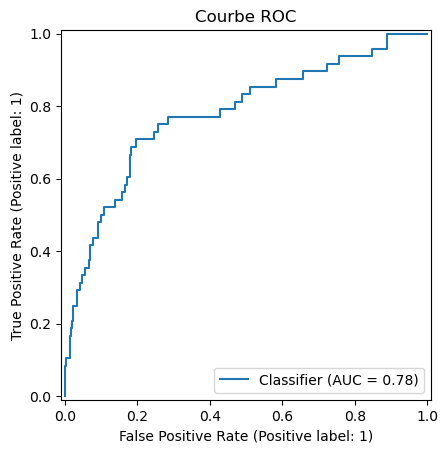

In [7]:
# Évaluation sur l'ensemble de test
y_test_numeric = y_test.map({'No': 0, 'Yes': 1})
y_pred = random_search.predict(X_test)
y_score = random_search.predict_proba(X_test)[:, 1]

print('AUC ROC sur le test set :', roc_auc_score(y_test_numeric, y_score))
print('Accuracy sur le test set :', accuracy_score(y_test, y_pred))

# Courbe ROC
RocCurveDisplay.from_predictions(y_test_numeric, y_score)
plt.title('Courbe ROC')
plt.show()